In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The similarity between click through rates and conversion is that they are both 1 and 0. Either you click 1 or you dont 0 or either you convert 1 or you dont 0. Statistically speaking, they exibit the bernolli's distribution aka discrete probability distribution

### Data Wrangling

In [3]:
# checking to see if there are any users in control that saw new page and users in treatment that saw old page

df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

looks like some users in the control group saw the new page and the user in the treatment group also saw the old page.

Since we are trying to get the unique user for each group, it is advised to drop those anomalies

In [4]:
print(df.shape)
df_better = df.loc[(df.group == 'control') & (df.landing_page == 'old_page') | (df.group == 'treatment') & (df.landing_page == 'new_page')]
print(df_better.shape)

(294478, 5)
(290585, 5)


About 4k observation has been removed

In [6]:
# sanity check
df_better.groupby(['group', 'landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [7]:
# now check duplicates user_id
df_better['user_id'].duplicated().sum()

1

In [11]:
# finding that user_id 
df_better[df_better.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


    The user encountered the landing page twice and still didn't convert 

In [12]:
# drop the second occurence of the user
df_better = df_better.drop_duplicates(subset=['user_id'], keep='first')
df_better.shape

(290584, 5)

### Exploratory Data Analysis

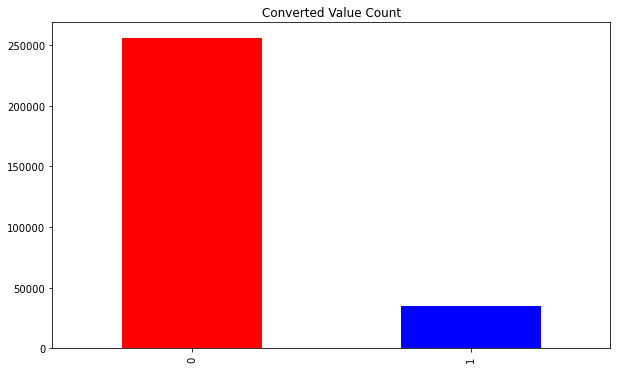

0    88.04
1    11.96
Name: converted, dtype: float64

In [23]:
# what's the proportion of converted?
df_better['converted'].value_counts().plot.bar(figsize=(10,6), color=['r', 'b'], title='Converted Value Count')
plt.show()
(df_better['converted'].value_counts(normalize=True)*100).round(2)

88% of the users did not convert, while approx 12% of the users converted. This means that for 10 users 8 will not convert while other 2 will convert. Basically

Text(0.5, 1.0, 'Proportion of each group based on user counts and converted')

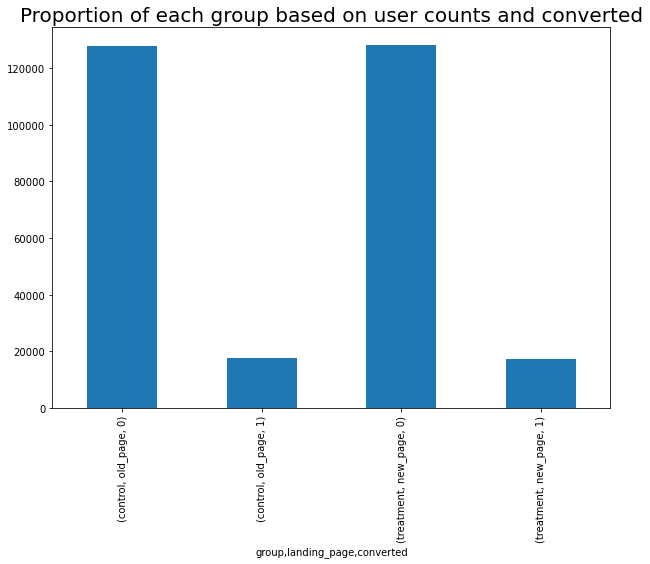

In [17]:
# let check the proportion of each group
df_better.groupby(['group', 'landing_page', 'converted']).size().plot(kind='bar', figsize=(10, 7))
plt.title('Proportion of each group based on user counts and converted', size=20)

The data shows that there is no diffrence in the conversion rate of users, but we can still prove this with more stats power using the chi_contingency with well crafted data

Text(0.5, 1.0, 'Landing Page Distribution')

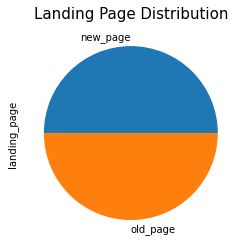

In [18]:
# are the user evenly separated
df_better['landing_page'].value_counts().plot(kind='pie')
plt.title('Landing Page Distribution', size=15)

Evenly separated yes? OfCourse

### Data Preparation

In [19]:
# Re-arranged data into 2X2 for Chi-Squared

# 1 Split group into 2 separate DataFrames
control = df_better[df_better['group'] == 'control']
treatment = df_better[df_better['group'] == 'treatment']

# control-click, control-noclick, treatment-click, treatment-noclick
control_click = control.converted.sum()
control_noclick = control.converted.size - control.converted.sum()

treatment_click = treatment.converted.sum()
treatment_noclick = treatment.converted.size - treatment.converted.sum()

# 3 create an array
T = np.array([[control_click, control_noclick], [treatment_click, treatment_noclick]])

In [27]:
from scipy import stats

p_value = stats.chi2_contingency(T, correction=False)[1]
print(p_value)

0.18988337448194853


Since p-value is approx 19%, using a 5% level of significance, inference can be that

1. p-value is greater than alpha
2. null hypothesis is not rejected (There is no significance difference in conversion between the old and new webpage)

In [29]:
# Just to butress with a sanity check
control_group = control_click / (control_click+ control_noclick)
treatment_group = treatment_click / (treatment_click+treatment_noclick)

print("control class: ", control_group)
print("treatment class: ", treatment_group)

control class:  0.1203863045004612
treatment class:  0.11880806551510564


Well since the diffrence between the 2 group is very minimal that is according to the conversion rate between them the difference is very low then we can accept our conclusion and say **null hypothesis is not rejected**